# Варіант 2
Номер студенського: 11307986
86 mod 7 = 2

#### Отже аналізуємо champagne.csv


In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 20, 10
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [228]:
champagne = pd.Series.from_csv('data/champagne.csv')
champagne_missed = pd.Series.from_csv('data/champagne_missed.csv')

/Users/tbatsenko/ml/lib/python3.7/site-packages/pandas/core/series.py:4141: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [229]:
champagne.head()

1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
dtype: int64

#### Great, looks like the data is already prepared - no need to process it

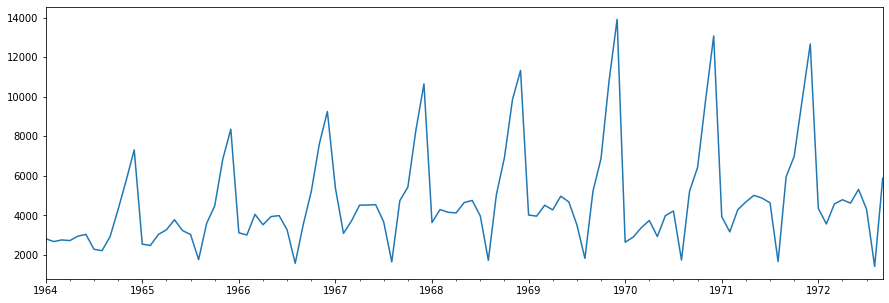

In [230]:
champagne.plot(figsize=(15, 5))

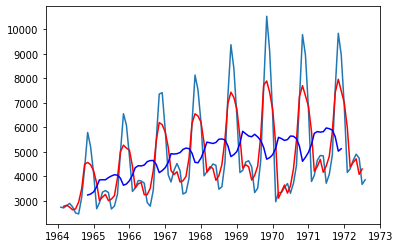

In [231]:
a = champagne.rolling(3, center=True).mean()
b = champagne.rolling(5, center=True).mean()
c = champagne.rolling(20, center=True).mean()

plt.plot(a)
plt.plot(b, color='red')
plt.plot(c, color='blue')


## 1. Валідація двох альтернатив: additive VS multiplicative;

- Level: is the average value in the series.
- Trend: is the increasing or decreasing value in the series.
- Seasonality: is the repeating the short-term cycle in the series.
- Noise: is the random variation in the series.

If it is a time series you are to analyze, the traditional components are the trend, the seasonal component, the cyclical movement and the irregular component.

- If seasonality tends to be constant over time, the additive model is suggestive.

- If however the seasonality seems to increase with time then the multiplicative model is suggestive. 

### Additive model to analyse Seasonality: 
```y(t) = Level + Trend + Seasonality + Noise```

In [232]:
decomposition_additive = seasonal_decompose(champagne, model='additive')

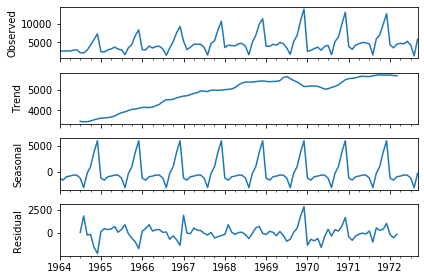

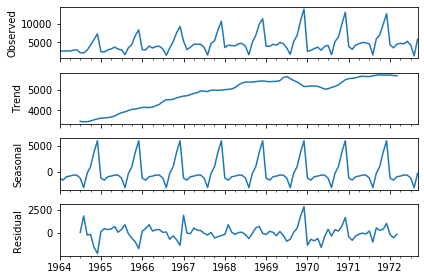

In [233]:
decomposition_additive.plot()

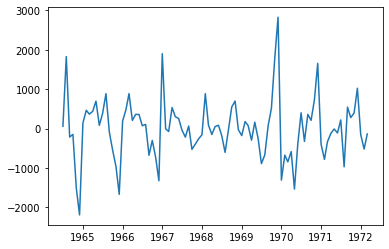

In [234]:
additive_residuals = decomposition_additive.resid.dropna()
plt.plot(additive_residuals)

### Multiplicative Model
```y(t) = Level * Trend * Seasonality * Noise```


In this situation, trend and seasonal components are multiplied and then added to the error component. It is not linear, can be exponential or quadratic and represented by a curved line as below:


Different from the additive model, the multiplicative model has an increasing or decreasing amplitude and/or frequency over time.

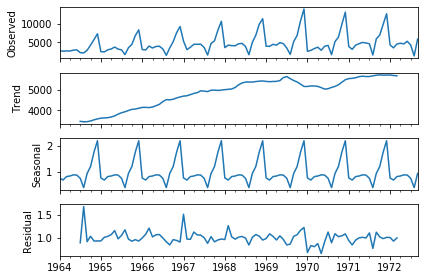

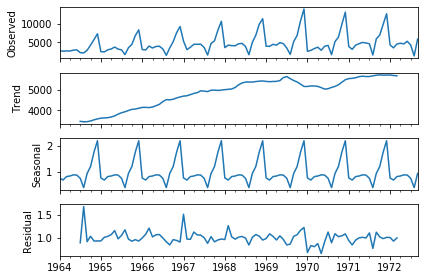

In [235]:
decomposition_multiplicative = seasonal_decompose(champagne, model='multiplicative')
decomposition_multiplicative.plot()

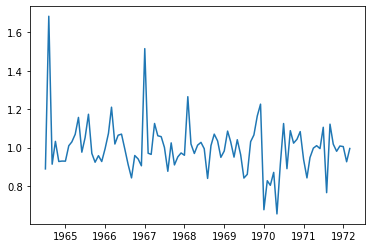

In [236]:
multiplicative_residuals = decomposition_multiplicative.resid.dropna()
plt.plot(multiplicative_residuals)

### After decomposing our data, we need to compare the residuals.

As we’re just trying to classify the time series, we don’t need to do anything particularly sophisticated – a big part of this exercise is to produce a quick function that could be used to perform an initial classification in a batch processing environment so simpler is better.

We’re going to check the whether how much correlation between data points is still encoded within the residuals. 

This is the Auto-Correlation Factor (ACF) and it has a function for calculating it. 

As some of the correlations could be negative ```we will select the type with the smallest sum of squares of correlation values.```


[1.0, 0.06609076220873411, 0.0019122083413211648, 0.026911839601621232, 0.11548875194194382, 0.056087980320244105]
1.2664915424138645


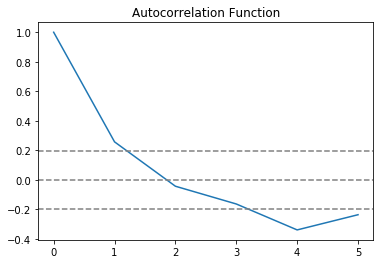

In [237]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
additive_residuals_lag_acf = acf(additive_residuals, nlags=5)
#Plot ACF: 
plt.plot(additive_residuals_lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Calculate sum of squares of correlation values.
additive_residuals_lag_acf = [x**2 for x in additive_residuals_lag_acf]
print(additive_residuals_lag_acf)
print(sum(additive_residuals_lag_acf))

1.0418616237749534


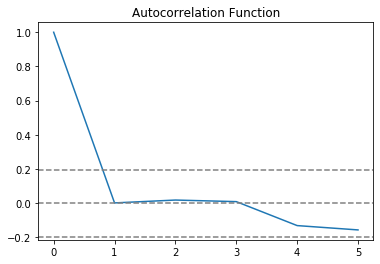

In [238]:
#ACF and PACF plots:
multiplicative_residuals_lag_acf = acf(multiplicative_residuals, nlags=5)
#Plot ACF: 
plt.plot(multiplicative_residuals_lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Calculate sum of squares of correlation values.
multiplicative_residuals_lag_acf = [x**2 for x in multiplicative_residuals_lag_acf]
print(sum(multiplicative_residuals_lag_acf))

In [239]:
if sum(multiplicative_residuals_lag_acf) > sum(additive_residuals_lag_acf): 
    print("Better use Additive model")
else: 
    print("Better use Multiplicative model")

Better use Multiplicative model


## 2. Описова частина (Moving Average, Differencing, Exponential Smoothing, Stationarity);

### Moving Average

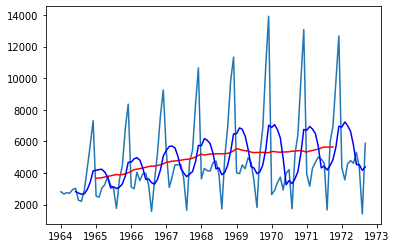

In [240]:
champagne_moving_avg_center = champagne.rolling(24, center=True).mean()
champagne_moving_avg_right = champagne.rolling(6, center=False).mean()
plt.plot(champagne)
plt.plot(champagne_moving_avg_center, color='red')
plt.plot(champagne_moving_avg_right, color='blue')


### Differencing

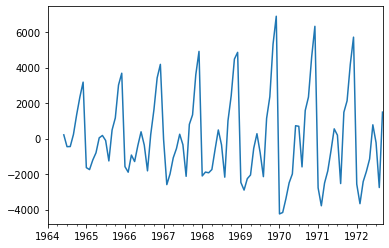

In [241]:
champagne_ma_diff = champagne - champagne_moving_avg_right
champagne_ma_diff.plot()

In [242]:
np.nanmean(champagne_ma_diff)

35.22499999999997

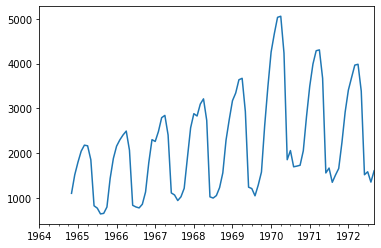

In [243]:
champagne_ma_diff.rolling(6).std().plot()

### Stationarity

### Let's define our stationarity_test function.

We will be using Augmented Dickey-Fuller test. The statsmodels library provides the adfuller() function that implements the test.

- The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure).
- The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

We interpret this result using the p-value from the test. 
A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

We will take that ```threshold = 5%``` 
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [244]:
from statsmodels.tsa.stattools import adfuller
def stationarity_test(data):
    
    rolmean = data.rolling(6).mean()
    rolstd = data.rolling(6).std()

    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    # Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(data, autolag='AIC')
    print(dftest)     
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)    

### To say that the data is stationary we should have : ```p-value < 0.05```

Results of Dickey-Fuller Test:
(-1.8335930563276193, 0.36391577166024686, 11, 93, {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}, 1478.4633060594724)
Test Statistic                 -1.833593
p-value                         0.363916
#Lags Used                     11.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


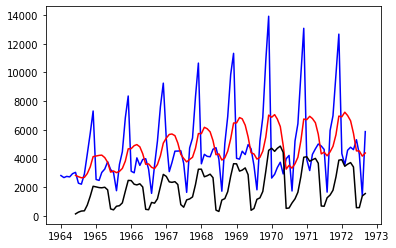

In [245]:
stationarity_test(champagne)

### So we see that the initial data is not stationary because : ```p-value = 0.36```

Results of Dickey-Fuller Test:
(-2.1988963406585205, 0.20664626536726233, 11, 87, {'1%': -3.5078527246648834, '5%': -2.895382030636155, '10%': -2.584823877658872}, 1402.6372813525882)
Test Statistic                 -2.198896
p-value                         0.206646
#Lags Used                     11.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64


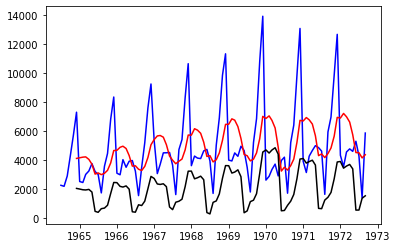

In [246]:
stationarity_test(champagne[6:])

### Exponential Smoothing

In [247]:
expwighted_avg = champagne.ewm(span=6).mean()

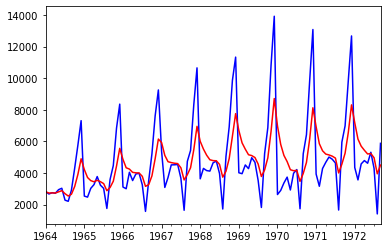

In [248]:
champagne.plot(color="blue", label="Original")
expwighted_avg.plot(color="red", label="EWMA")

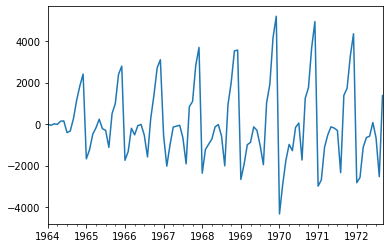

In [249]:
champagne_exp_diff = champagne - expwighted_avg
champagne_exp_diff.plot()

Results of Dickey-Fuller Test:
(-4.1125459422207875, 0.0009232969815981617, 11, 93, {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}, 1419.7424911819912)
Test Statistic                 -4.112546
p-value                         0.000923
#Lags Used                     11.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


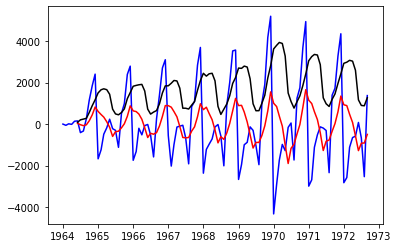

In [250]:
stationarity_test(champagne_exp_diff)

### Now we see that after applying exponential smoothing the transformed data and it is now  stationary because

### ```p-value = 0.000923```, which is less then ``` 0.05```

## 3. Валідація двох альтернатив приведення до стаціонарного ряду: decomposition VS differencing;

### Differencing

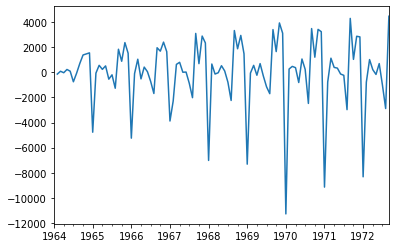

In [251]:
champagne_diff = champagne - champagne.shift(1)
champagne_diff.plot()

Results of Dickey-Fuller Test:
(-7.189896448050998, 2.519620447387099e-10, 11, 92, {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}, 1466.8267262915892)
Test Statistic                -7.189896e+00
p-value                        2.519620e-10
#Lags Used                     1.100000e+01
Number of Observations Used    9.200000e+01
Critical Value (1%)           -3.503515e+00
Critical Value (5%)           -2.893508e+00
Critical Value (10%)          -2.583824e+00
dtype: float64


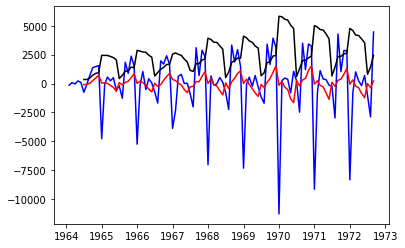

In [252]:
champagne_diff.dropna(inplace=True)
stationarity_test(champagne_diff)

### Decomposition

In [253]:
from statsmodels.tsa.seasonal import seasonal_decompose

def _decompose(data, freq):
    decomposition = seasonal_decompose(data, freq=freq)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    return residual

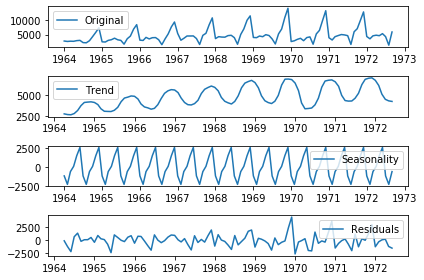

In [254]:
res = _decompose(champagne, 6)

Results of Dickey-Fuller Test:
(-14.683214687299298, 3.1323255221471598e-27, 10, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 1318.9775207123605)
Test Statistic                -1.468321e+01
p-value                        3.132326e-27
#Lags Used                     1.000000e+01
Number of Observations Used    8.800000e+01
Critical Value (1%)           -3.506944e+00
Critical Value (5%)           -2.894990e+00
Critical Value (10%)          -2.584615e+00
dtype: float64


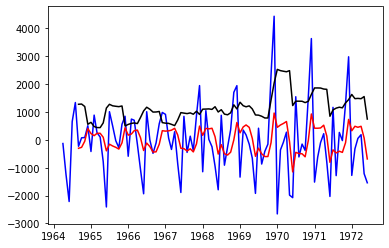

In [255]:
res.dropna(inplace=True)
stationarity_test(res)

#### We see that decomposition gives better p-value (smaller one)

## 4. Тренування та валідація MA, AR, ARMA, ARIMA моделей;

In [256]:
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(res, nlags=5)
lag_pacf = pacf(res, nlags=5, method='ols')

[ 1.00000000e+00  2.40901349e-05 -1.78783869e-01 -4.68074930e-02
  6.58490363e-02  2.42536513e-02]


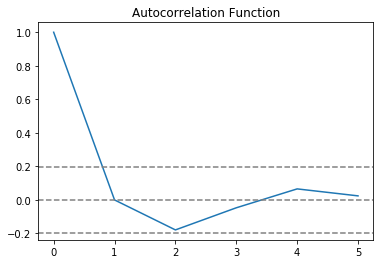

In [257]:
#Plot ACF: 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
print(lag_acf)

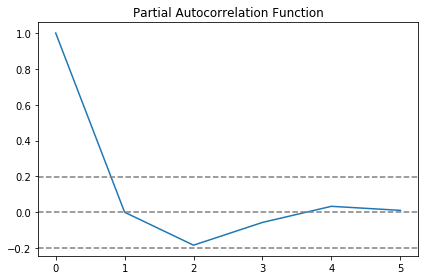

In [258]:
#Plot PACF:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### AR model

/Users/tbatsenko/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 11914.5478')

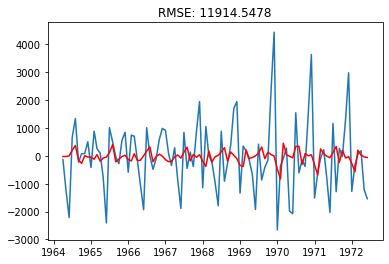

In [306]:
model = ARIMA(res, order=(2, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(res)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((results_AR.fittedvalues-res)**2)))

/Users/tbatsenko/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 10599.7468')

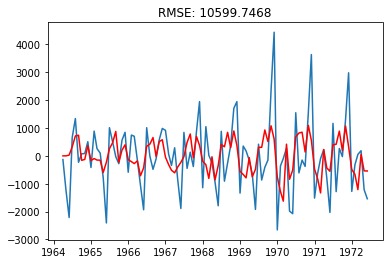

In [307]:
model = ARIMA(res, order=(0, 0, 3))  
results_MA = model.fit(disp=-1)  
plt.plot(res)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((results_MA.fittedvalues-res)**2)))

/Users/tbatsenko/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 10652.3066')

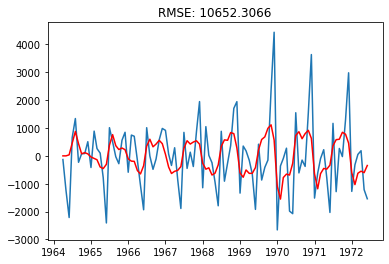

In [336]:
model = ARIMA(res, order=(2, 0, 1))  
results_ARMA = model.fit(disp=-1)  
plt.plot(res)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((results_ARMA.fittedvalues-res)**2)))

/Users/tbatsenko/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 11002.8859')

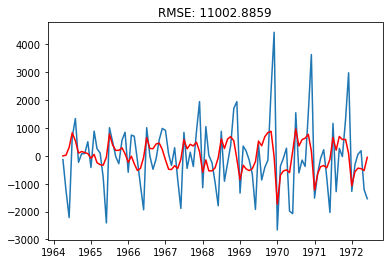

In [337]:
model = ARIMA(res, order=(1, 0, 1))  
results_ARMA = model.fit(disp=-1)  
plt.plot(res)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((results_ARMA.fittedvalues-res)**2)))

/Users/tbatsenko/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/tbatsenko/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 16792.6854')

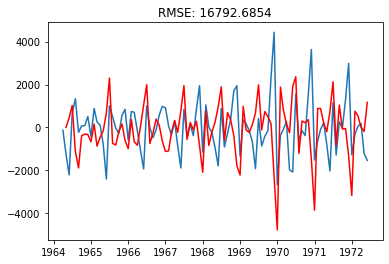

In [351]:
# 2,1,1 ARIMA Model
model = ARIMA(res, order=(2, 1, 1))
results_ARIMA = model.fit(disp=0)
plt.plot(res)
plt.plot(results_ARIMA.fittedvalues, color='red')
RMSE_ARIMA_1 = (results_ARIMA.fittedvalues.dropna()-res)**2
RMSE_ARIMA_1 = RMSE_ARIMA_1.dropna()
plt.title('RMSE: %.4f'% np.sqrt(sum(RMSE_ARIMA_1)))

## 5.  Генерація фіч та валідація ML моделей (тут на Ваш смак будь-які з відомих регресивних моделей). 
##### Буде вважатися плюсом додавання додаткових екзогенних факторів, таких як опади, площі і тп.

In [263]:
ts_missed = pd.Series.from_csv("data/champagne_missed.csv")

/Users/tbatsenko/ml/lib/python3.7/site-packages/pandas/core/series.py:4141: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [264]:
ts_missed.head()

1964-01-01    2815.0
1964-02-01    2672.0
1964-03-01    2755.0
1964-04-01    2721.0
1964-05-01    2946.0
dtype: float64

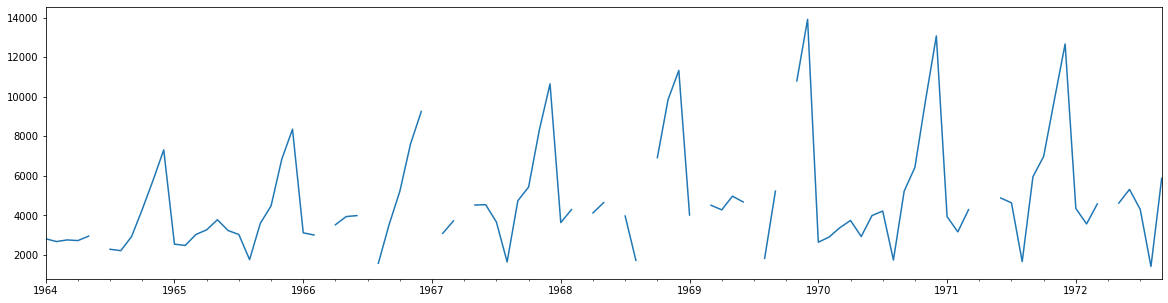

In [265]:
ts_missed.plot(figsize=(20, 5))

### Interpolation

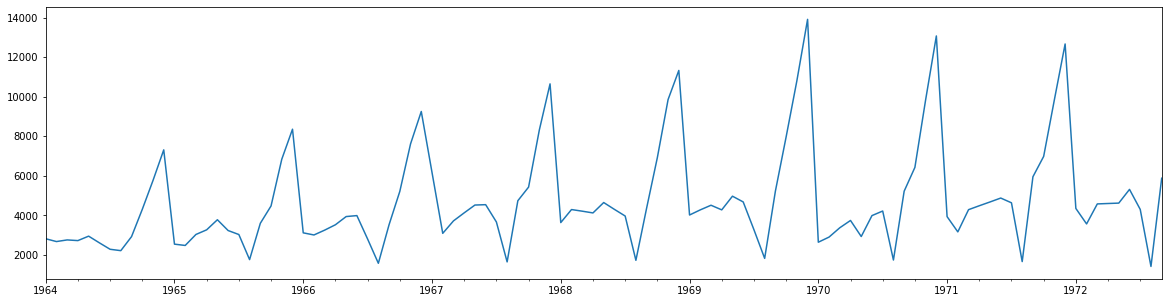

In [266]:
ts_missed.interpolate("time").plot(figsize=(20, 5))

In [267]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [268]:
ts_missed_cp = ts_missed

In [269]:
df = pd.DataFrame([
    [ ts_missed.iloc[i-12],
      ts_missed.iloc[i-1],
      ts_missed.iloc[i+1],
      ts_missed.iloc[i+12],  
      ts_missed.iloc[i]] 
     for i in range(11, len(ts_missed)-12)
], columns=["prev_year", "prev_month", "next_month", "next_year", "current"])

In [270]:
df_cp = df.dropna()

In [271]:
df_cp.head()

,prev_year,prev_month,next_month,next_year,current
0,5877.0,5764.0,2541.0,8357.0,7312.0
1,2815.0,7312.0,2475.0,3113.0,2541.0
2,2672.0,2541.0,3031.0,3006.0,2475.0
4,2721.0,3031.0,3776.0,3523.0,3266.0
5,2946.0,3266.0,3230.0,3937.0,3776.0


In [272]:
df_cp.shape

(35, 5)

In [273]:
lr = LinearRegression()
lr.fit(df_cp.loc[:, df_cp.columns != 'current'], df_cp["current"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [274]:
def get_value_by_index(ts, i):
    if i >=0 and i < len(ts) and not np.isnan(ts.iloc[i]):
        return ts.iloc[i]
    return ts.mean()

In [275]:
predictions = []
for i in range(len(ts_missed)):
    predict = lr.predict(np.array([
        get_value_by_index(ts_missed, i-12),
        get_value_by_index(ts_missed, i-1),
        get_value_by_index(ts_missed, i+1),
        get_value_by_index(ts_missed, i+12),
    ]).reshape(-1, 4))
    predictions.append(predict[0])
predictions = pd.Series(predictions, index=ts_missed.index)

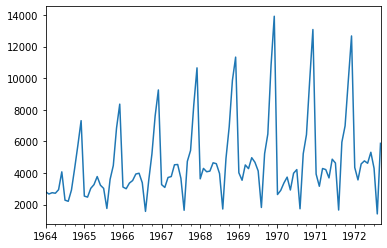

In [276]:
ts_filled = ts_missed.fillna(predictions)
ts_filled.plot()

In [277]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

In [278]:
def test_stationary(ts):
    result = adfuller(ts)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [279]:
ts_train = ts_filled[ts_filled.index<"1971"]
ts_valid = ts_filled[ts_filled.index>="1971"]

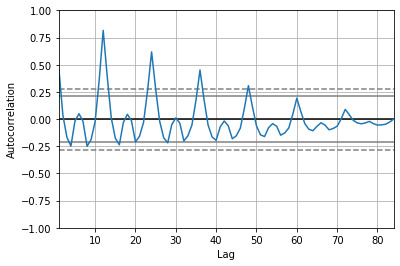

In [280]:
autocorrelation_plot(ts_train)

In [281]:
test_stationary(ts_train)

ADF Statistic: -1.993503
p-value: 0.289429
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589


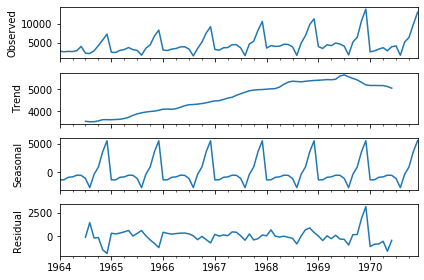

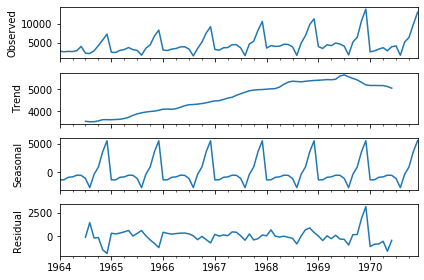

In [282]:
decompose = seasonal_decompose(ts_train)
decompose.plot()

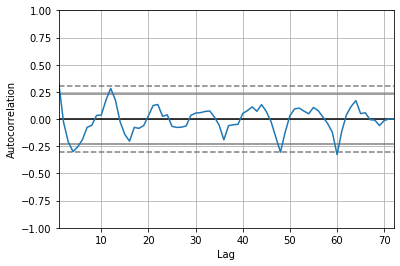

In [283]:
residuals = decompose.resid.dropna()
autocorrelation_plot(residuals)

In [284]:
test_stationary(residuals)

ADF Statistic: -6.750087
p-value: 0.000000
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592


/Users/tbatsenko/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/tbatsenko/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


## 6. Висновки щодо того, яку модель краще використовувати;

/Users/tbatsenko/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 10599.7468')

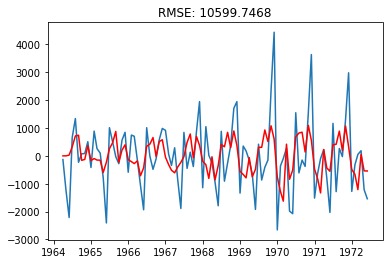

In [338]:
model = ARIMA(res, order=(0, 0, 3))  
results_MA = model.fit(disp=-1)  
plt.plot(res)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((results_MA.fittedvalues-res)**2)))

#### MA is the best model with RMSE = 10599

## 7.  Прогноз на наступний рік

In [343]:
model = ARIMA(residuals, order=(0, 0, 3))
model_fit = model.fit()  

/Users/tbatsenko/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


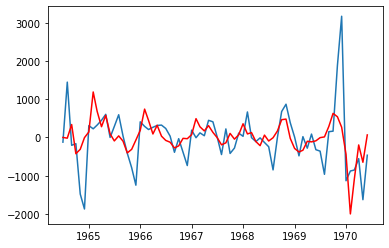

In [346]:
forecast = model_fit.fittedvalues
plt.plot(residuals)
plt.plot(forecast, color='red')
plt.show()

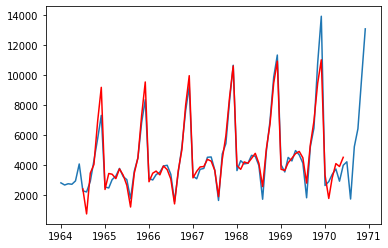

In [347]:
plt.plot(ts_train)
plt.plot(forecast.add(decompose.seasonal).add(decompose.trend).dropna(), color="red")

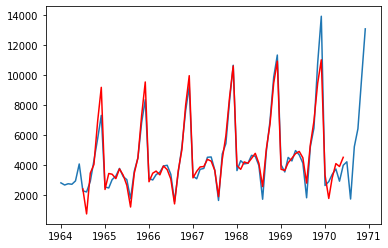

In [352]:
plt.plot(ts_train)
plt.plot(forecast.add(decompose.seasonal).add(decompose.trend).dropna(), color="red")

## The end